### Final Project for Cosmology with Zoltan Haiman @ Columbia

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import camb
from camb import model, initialpower
import emcee
import corner

In [2]:
# download the data from
# https://lambda.gsfc.nasa.gov/data/map/dr5/dcp/spectra/wmap_tt_spectrum_9yr_v5.txt
# and read it in

data = np.loadtxt("./wmap_tt_spectrum_9yr_v5.txt")

# the data has Columns
# multipole l,
# TT spectrum,
# error derived from diagonal elements of the covariance matrix,
# portion of it comming from measurement,
# portion comming from cosmic variance

l_data = data[:, 0]
TT = data[:, 1]
err1 = data[:, 2]
err2 = data[:, 3]
err3 = data[:, 4]

print(l_data.min(), l_data.max())
print(l_data)
print(l_data.shape)

2.0 1200.0
[   2.    3.    4. ... 1198. 1199. 1200.]
(1199,)


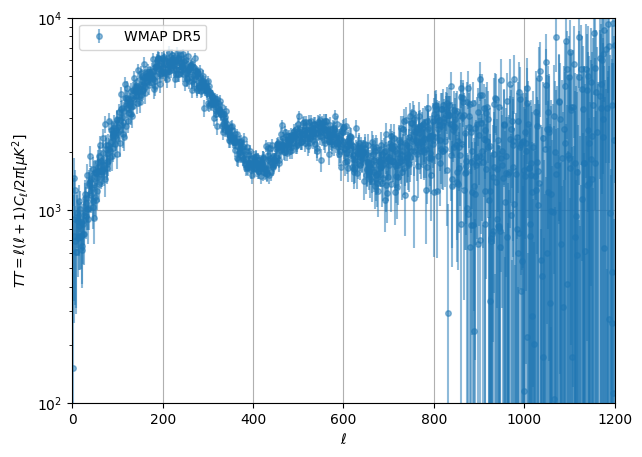

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.errorbar(l_data, TT, yerr=err1, fmt="o", label="WMAP DR5", alpha=0.5, markersize=4)
ax.set(
    xlabel=r"$\ell$",
    ylabel=r"$TT = \ell(\ell+1)C_\ell/2\pi [\mu K^2]$",
    xlim=(0, 1200),
    ylim=(100, 10000),
    yscale="log",
)
ax.grid()
ax.legend()
plt.show()

Here, throughout this analysis, we adopt the following when noted, from [Hinshaw et al](https://arxiv.org/pdf/1212.5226)

### now see how CAMB works

used this tutorial notebook as a starting point 
https://camb.readthedocs.io/en/latest/CAMBdemo.html

<img src="henshaw_etal.png" alt="Example Image" width="500" />


In [20]:
wmap_omegab = 0.0464
wmap_omegac = 0.235
zoltan_H0 = 72


def model_TT(omega_baryon=0.0464, omega_coldDM=0.235, omega_k=0, H0=72, lmax=1200):

    h = H0 / 100.0

    # from the Wmap 7 year results
    ombh2 = omega_baryon * h**2
    omch2 = omega_coldDM * h**2
    Omega_matter = omega_baryon + omega_coldDM

    pars = camb.set_params(
        H0=H0,  # Hubble parameter today
        ombh2=ombh2,  # physical baryon density
        omch2=omch2,  #  physical density in cold dark atter
        omk=omega_k,  # flat, Omega_K curveture parameter
        mnu=0,  # sum of neutrino masses
        lmax=1200,
      
    )
    results = camb.get_results(pars)

    # part of resultsreults
    # print(results)
    # print(results.omega_de)
    # derived_params = results.get_derived_params()
    # print(derived_params["omega_da"])
    # get dictionary of CAMB power spectra

    powers = results.get_cmb_power_spectra(
        pars,
        CMB_unit="muK",
        lmax=lmax,
    )

    # plot the total lensed CMB power spectra versus unlensed, and fractional difference
    totCL = powers["total"]
    unlensedCL = powers["unlensed_scalar"]

    # print(totCL.shape)
    # Python CL arrays are all zero based (starting at L=0), Note L=0,1 entries will be zero by default.
    # The different CL are always in the order TT, EE, BB, TE (with BB=0 for unlensed scalar results).\

    totCL = totCL[:, :]
    unlensedCL = unlensedCL[:, :]
    ls = np.arange(totCL.shape[0])

    # print(totCL.shape)

    # our data starts at 2, so we need to remove the first two elements
    return ls[2:], totCL[2:], unlensedCL[2:], results.omega_de


ls, totCL, unlensedCL, omega_lambda = model_TT(
    omega_baryon=0.0464, omega_coldDM=0.235, omega_k = 0, H0=72
)

[   2    3    4 ... 1198 1199 1200]


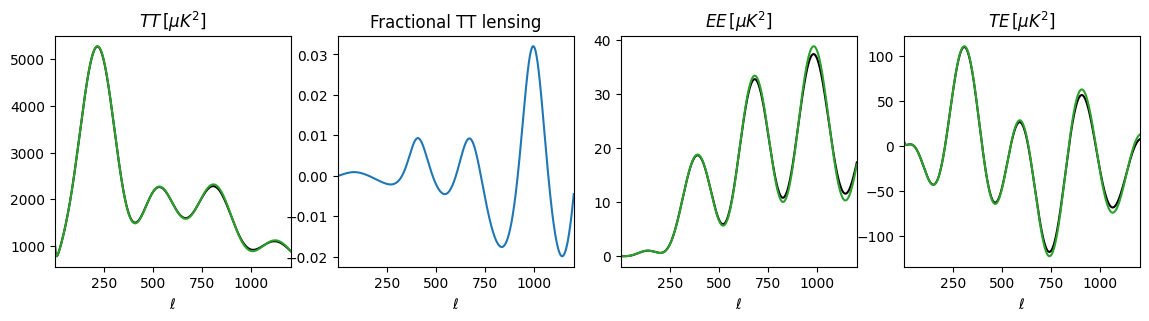

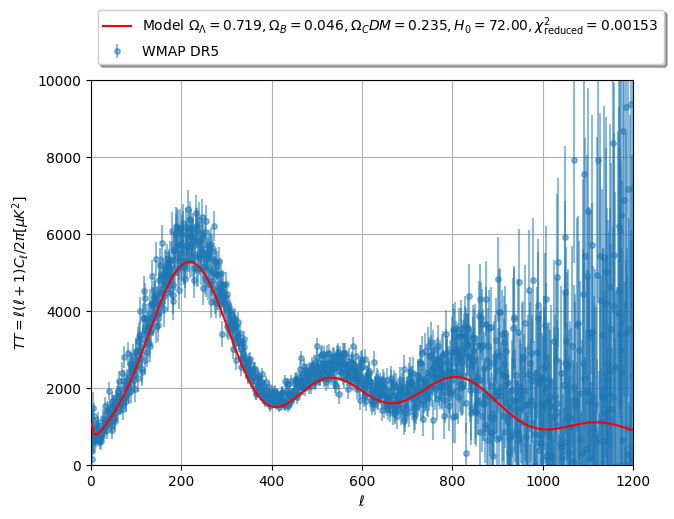

In [21]:
def ch2(data, model, error):
    """standard chi squared function

    Args:
        data (_type_):  data points from wmap
        model (_type_):  CAMB model
        error (_type_): error in the data

    Returns:
        _type_: _description_
    """
    return np.sum((data - model) ** 2 / error**2) / len(data)


def reduced_ch2(data, model, error, n_params):
    return ch2(data, model, error) / (len(data) - n_params)


fig, ax = plt.subplots(1, 4, figsize=(14, 3), dpi=100)
print(ls)
ax[0].plot(ls, totCL[:, 0], color="k")
ax[0].plot(ls, unlensedCL[:, 0], color="C2")
ax[0].set_title(r"$TT\, [\mu K^2]$")
ax[1].plot(ls[2:], 1 - unlensedCL[2:, 0] / totCL[2:, 0])
ax[1].set_title(r"Fractional TT lensing")
ax[2].plot(ls, totCL[:, 1], color="k")
ax[2].plot(ls, unlensedCL[:, 1], color="C2")
ax[2].set_title(r"$EE\, [\mu K^2]$")
ax[3].plot(ls, totCL[:, 3], color="k")
ax[3].plot(ls, unlensedCL[:, 3], color="C2")
ax[3].set_title(r"$TE\, [\mu K^2]$")
for ax in ax.reshape(-1):
    ax.set_xlim([2, 1200])
    ax.set_xlabel(r"$\ell$")

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

initial_chi2 = ch2(TT, totCL[:, 0], err1)
initial_reduced_chi2 = reduced_ch2(TT, totCL[:, 0], err1, 3)

ax.errorbar(
    l_data,
    TT,
    yerr=err1,
    fmt="o",
    label="WMAP DR5",
    alpha=0.5,
    markersize=4,
)
ax.set(
    xlabel=r"$\ell$",
    ylabel=r"$TT = \ell(\ell+1)C_\ell/2\pi [\mu K^2]$",
    xlim=(0, 1200),
    ylim=(0, 10000),
)
ax.plot(
    ls,
    totCL[:, 0],
    color="r",
    zorder=5,
    label=r"Model $\Omega_\Lambda = {:.3f}, \Omega_B = {:.3f}, \Omega_CDM = {:.3f}, H_0 = {:.2f}, \chi^2_{{\rm reduced}} = {:.5f}$".format(
        omega_lambda, wmap_omegab, wmap_omegac, zoltan_H0, initial_reduced_chi2
    ),
)
ax.grid()
ax.legend(bbox_to_anchor=(0, 1.2), loc="upper left", fancybox=True, shadow=True)
plt.show()

### here we can make functions that can determine what a good fit is

one thing to do would be to define a negative log probability. which assumes that the data's errors are gaussian. 

we have to assume a prior, which in this case, we can just assume a top hat around some acceptable range that is reasonable.

we can use the emcee package by [dfm](https://dfm.io/about/)

In [28]:
def compute_omega_lambda(omega_baryon, omega_coldDM):
    """compute the derived quantity Omega_Lambda."""
    return 1.0 - omega_baryon - omega_coldDM


derived_omega_lambdas = []


def log_likelihood(theta, ell, c_ell, c_ell_err):
    """log likelihood function that we will try to minimize

    Args:
        theta (_type_): array of parameters
        ell (_type_): _description_
        c_ell (_type_): _description_
        c_ell_err (_type_): _description_

    Returns:
        _type_: _description_
    """
    O_baryon, O_coldDM, O_k  = theta

    ls, model, unlensedCL, omega_lambda = model_TT(O_baryon, O_coldDM, H0=72)
    derived_omega_lambdas.append(omega_lambda)
    # the different CL are always in the order TT, EE, BB, TE
    pwr_spectrum = model[:, 0]

    chisq = ch2(c_ell, c_ell_err, pwr_spectrum)
    return -0.5 * chisq


# acceptable ranges
omega_baryon_acc = [0.02, 0.5]  # "true" value is 0.0464
omega_coldDM_acc = [0.1, 0.5]  # "true" value is 0.235
omega_k_acc = [-0.5, 0.5]
omega_lambda_acc = [0.23, 1.0]
# H0_acc = [60, 80]


def log_prior(theta):
    """log prior function that we will try to minimize

    Args:
        theta (_type_): array of parameters

    Returns:
        _type_: _description_
    """
    O_baryon, O_coldDM, O_k = theta
    if (
        omega_baryon_acc[0] < O_baryon < omega_baryon_acc[1]
        and omega_coldDM_acc[0] < O_coldDM < omega_coldDM_acc[1]
        and omega_k_acc[0] < O_k < omega_k_acc[1]
        # and O_coldDM > O_baryon
        # and O_coldDM + O_baryon == 0.26
        # and omega_lambda_acc[0] < O_lambda < omega_lambda_acc[1]
    ):
        return 0.0
    return -np.inf


def log_probability(theta, ell, c_ell, c_ell_err):
    """log probability function that we will try to minimize

    Args:
        theta (_type_): array of parameters
        ell (_type_): _description_
        c_ell (_type_): _description_
        c_ell_err (_type_): _description_

    Returns:
        _type_: _description_
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, ell, c_ell, c_ell_err)


# let's add the MCMC part
nwalkers = 128
n_iterations = 320
# uniform distribution of walkers
omega_baryon_walkers = np.random.uniform(
    omega_baryon_acc[0], omega_baryon_acc[1], nwalkers
)
omega_coldDM_walkers = np.random.uniform(
    omega_coldDM_acc[0], omega_coldDM_acc[1], nwalkers
)
omega_k_walkers = np.random.uniform(
    omega_k_acc[0], omega_k_acc[1], nwalkers
)
# omega_lambda_walkers = np.random.uniform(
#     omega_lambda_acc[0], omega_lambda_acc[1], nwalkers
# )
# H0_walkers = np.random.uniform(H0_acc[0], H0_acc[1], nwalkers)

# initial list of walkers
p0 = np.array([omega_baryon_walkers, omega_coldDM_walkers,omega_k_walkers]).T

In [ ]:
sampler = emcee.EnsembleSampler(
    nwalkers, p0.shape[1], log_probability, args=(l_data, TT, err1)
)
sampler.run_mcmc(p0, n_iterations, progress=True)

  9%|▉         | 30/320 [19:45<3:11:56, 39.71s/it]

we can look at convergence below

Text(0.5, 0, 'step number')

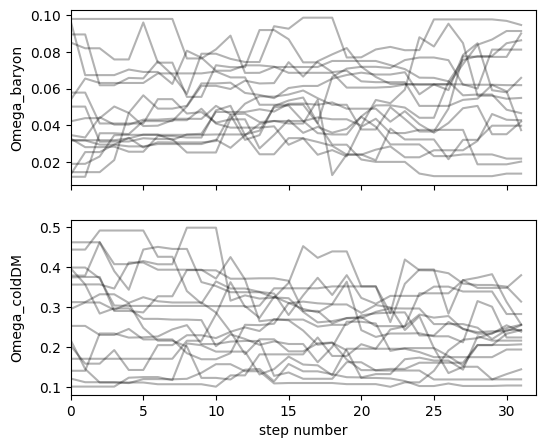

In [17]:
fig, axes = plt.subplots(2, figsize=(6, 5), sharex=True)
samples = sampler.get_chain()
labels = ["Omega_baryon", "Omega_coldDM", "Omega_lambda"]
for i in range(p0.shape[1]):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

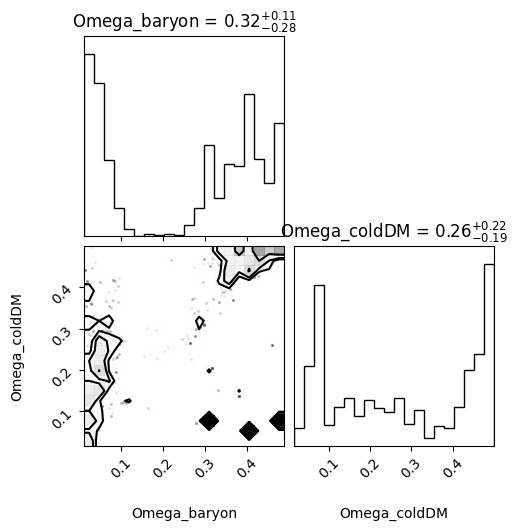

: 

In [ ]:
fig = corner.corner(sampler.flatchain, labels=labels, show_titles=True)

: 

: 

: 

: 